In [272]:
! git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [273]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import pandas as pd
import random
np.random.seed(0)

In [275]:
with open('german-traffic-signs/train.p','rb') as f:
  train_data=pickle.load(f)
with open('german-traffic-signs/valid.p','rb') as f:
  val_data=pickle.load(f)
with open('german-traffic-signs/test.p','rb') as f:
  test_data=pickle.load(f)
  
print(type(train_data))
X_train,y_train=train_data['features'], train_data['labels']
X_val,y_val=val_data['features'], val_data['labels']
X_test,y_test=test_data['features'], test_data['labels']
  

<class 'dict'>


In [276]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [0]:
assert(X_train.shape[0]==y_train.shape[0]),'no of train images not equal to no of labels'
assert(X_val.shape[0]==y_val.shape[0]),'no of train images not equal to no of labels'
assert(X_train.shape[1:]==(32,32,3)),'shape is not correct '
assert(X_val.shape[1:]==(32,32,3)),'shape is not correct '
assert(X_test.shape[1:]==(32,32,3)),'shape is not correct '

In [278]:
data=pd.read_csv('german-traffic-signs/signnames.csv')
print(data)


    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vechiles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

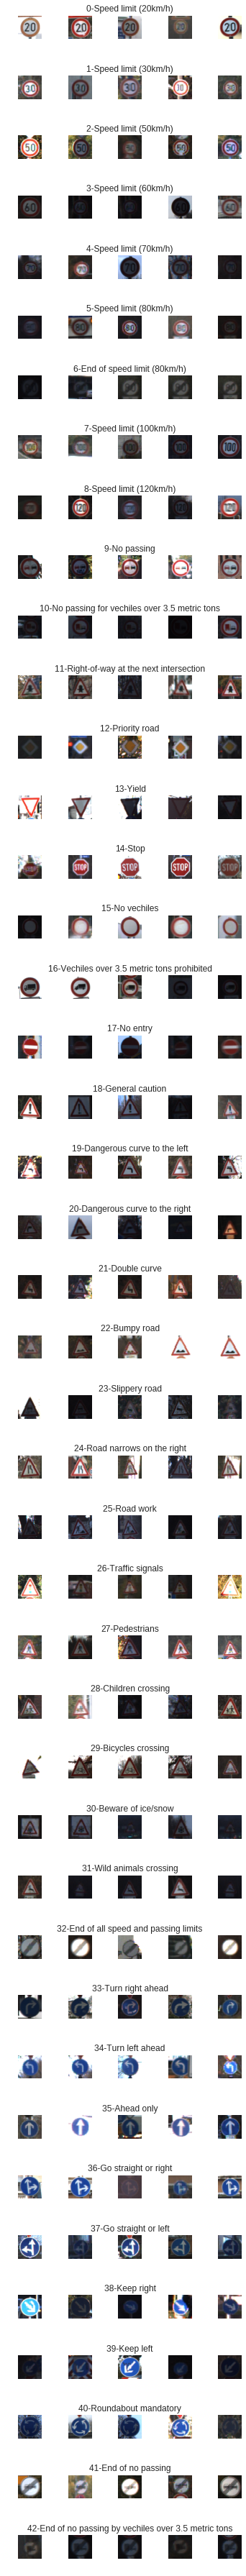

In [279]:
no_of_samples=[]

cols=5
no_of_classes=43 #0 to 9

fig,axes=plt.subplots(nrows=no_of_classes,ncols=cols,figsize=(5,50)) 
#multiple plots on the same figure; return a tuple with two values and instance of our figure and plot axes
fig.tight_layout()#deals with the overlap

for i in range(cols):
    for j,row in data.iterrows():#(index,series)
        x_selected=X_train[y_train==j]
        axes[j][i].imshow(x_selected[random.randint(0,len(x_selected-1) ),:,:],cmap='gray')
        axes[j][i].axis('off')# doesnt show pixels margin
        if i==2:
            axes[j][i].set_title(str(j)+'-'+row['SignName'])#displayes title with column index 2
            no_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0, 0.5, 'no of image')

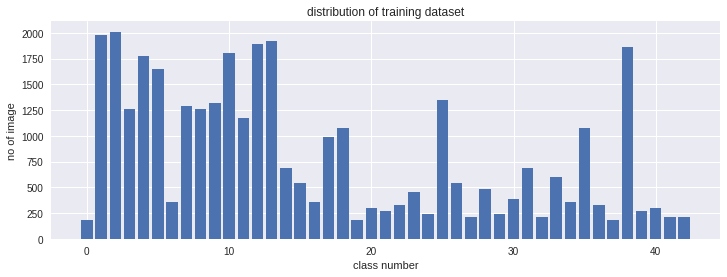

In [280]:
print(no_of_samples)
plt.figure(figsize=(12,4))
plt.bar(range(0,no_of_classes),no_of_samples)
plt.title('distribution of training dataset')
plt.xlabel('class number')
plt.ylabel('no of image')

(32, 32, 3)
36


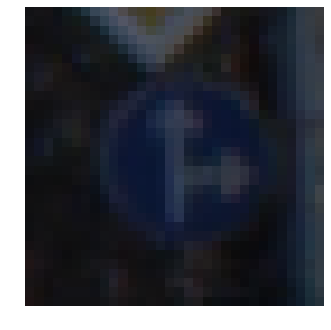

In [281]:
# preprocessing the images:
import cv2
plt.imshow(X_train[1000])
plt.axis('off')
print(X_train[1000].shape)
print(y_train[1000])

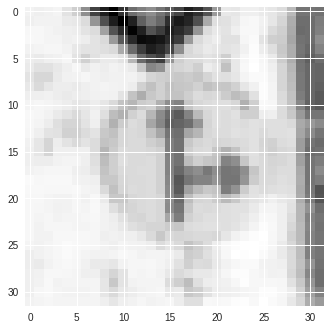

In [282]:
def grayscale(img):
  img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  return img

img=grayscale(X_train[1000])
plt.imshow(img)


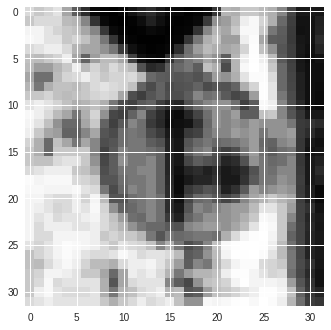

In [283]:
def equalize(img):
  img=cv2.equalizeHist(img)
  return img

img=equalize(img)
plt.imshow(img)

In [0]:
def preprocessing(img):
  img=grayscale(img)
  img=equalize(img)
  img=img/255
  return img

X_train=np.array(list(map(preprocessing,X_train)))
X_val=np.array(list(map(preprocessing,X_val)))
X_test=np.array(list(map(preprocessing,X_test)))

(-0.5, 31.5, 31.5, -0.5)

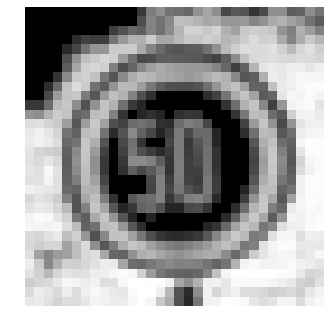

In [285]:
plt.imshow(X_train[random.randint(0,len(X_train)-1)])
plt.axis('off')

In [307]:
#add depth for proper processing in cnn
X_train=X_train.reshape(34799,32,32,1)
X_test=X_test.reshape(12630,32,32,1)
X_val=X_val.reshape(4410,32,32,1)

print(X_train.reshape)

<built-in method reshape of numpy.ndarray object at 0x7f0e2dba0a80>


In [0]:
#data augmaentaion process
from keras.preprocessing.image import ImageDataGenerator
datagen=ImageDataGenerator(width_shift_range=0.1,#10% of image width
                  height_shift_range=0.1,
                  zoom_range=0.2,#we can zoom as far as 0.8 & zoom in as close as 1.2
                  shear_range=0.1,
                  rotation_range=10)
datagen.fit(X_train)

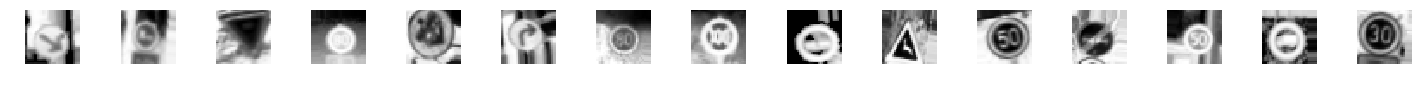

In [310]:
batches=datagen.flow(X_train,y_train,batch_size=20)
X_batch,y_batch=next(batches)

fig,axes=plt.subplots(1,15,figsize=(20,5))
fig.tight_layout()

for i in range(15):
  axes[i].imshow(X_batch[i].reshape(32,32))
  axes[i].axis('off')


In [0]:
# one hot encoding
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)
y_val=to_categorical(y_val)

In [0]:
# defing lent implementation
def modified_model():
  model=Sequential()
  model.add(Conv2D(60,(5,5),input_shape=(32,32,1),activation='relu'))
  model.add(Conv2D(60,(5,5),activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  
  model.add(Conv2D(30,(3,3),activation='relu'))
  model.add(Conv2D(30,(3,3),activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  
  model.add(Flatten())# reshape into 1D array
  model.add(Dense(500,activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dropout(0.5))
  model.add(Dense(no_of_classes,activation='softmax'))
  model.compile(Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
  return model
  

In [298]:
model=modified_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 4, 4, 30)          0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 480)               0         
__________

In [311]:
history=model.fit_generator(datagen.flow(X_train,y_train,batch_size=50),steps_per_epoch=2000,epochs=10,validation_data=(X_val,y_val),shuffle=1)

Epoch 1/10
2000/2000 [==============================] - 54s 27ms/step - loss: 0.6273 - acc: 0.8101 - val_loss: 0.0437 - val_acc: 0.9875
Epoch 2/10
2000/2000 [==============================] - 55s 28ms/step - loss: 0.2517 - acc: 0.9220 - val_loss: 0.0575 - val_acc: 0.9807
Epoch 3/10
2000/2000 [==============================] - 55s 27ms/step - loss: 0.1716 - acc: 0.9479 - val_loss: 0.0333 - val_acc: 0.9896
Epoch 4/10
2000/2000 [==============================] - 55s 27ms/step - loss: 0.1408 - acc: 0.9585 - val_loss: 0.0368 - val_acc: 0.9878
Epoch 5/10
2000/2000 [==============================] - 55s 28ms/step - loss: 0.1170 - acc: 0.9649 - val_loss: 0.0230 - val_acc: 0.9941
Epoch 6/10
2000/2000 [==============================] - 55s 27ms/step - loss: 0.1047 - acc: 0.9686 - val_loss: 0.0251 - val_acc: 0.9930
Epoch 7/10
2000/2000 [==============================] - 55s 28ms/step - loss: 0.0964 - acc: 0.9715 - val_loss: 0.0323 - val_acc: 0.9902
Epoch 8/10
2000/2000 [==========================

/usr/local/lib/python3.6/dist-packages/matplotlib/legend.py:798: UserWarning: Legend does not support 't' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
/usr/local/lib/python3.6/dist-packages/matplotlib/legend.py:798: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
/usr/local/lib/python3.6/dist-packages/matplotlib/legend.py:798: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
/usr/local/lib/python3.6/dist-packages/matp

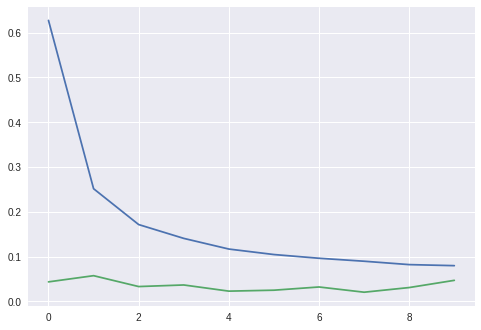

In [312]:
 plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend('training','validation')

/usr/local/lib/python3.6/dist-packages/matplotlib/legend.py:798: UserWarning: Legend does not support 't' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
/usr/local/lib/python3.6/dist-packages/matplotlib/legend.py:798: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
/usr/local/lib/python3.6/dist-packages/matplotlib/legend.py:798: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
/usr/local/lib/python3.6/dist-packages/matp

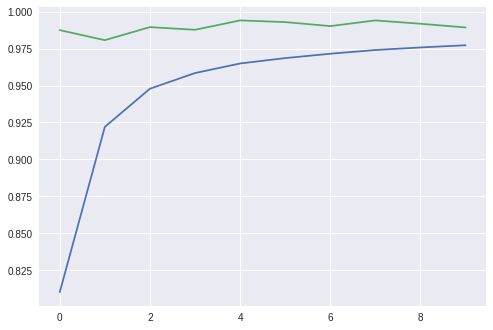

In [313]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend('trraining','validation')

In [314]:
score=model.evaluate(X_test,y_test,verbose=0)
print('test socre',score[0])
print('accuracy',score[1])

test socre 0.14756037616220025
accuracy 0.970308788617452


In [0]:
#fine tuning:(imrpve accuracy) dec learning rage, inc filters, add extra convolution layers
             #(to solve overfitting):add another dropout layer

Testing

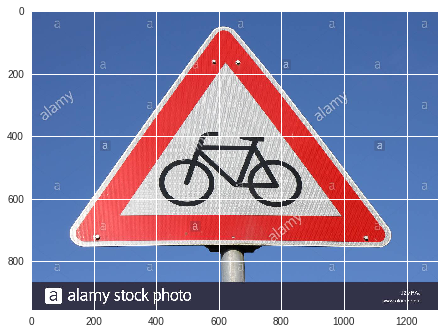

In [315]:
#fetch image
 
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))
 
 



(32, 32)


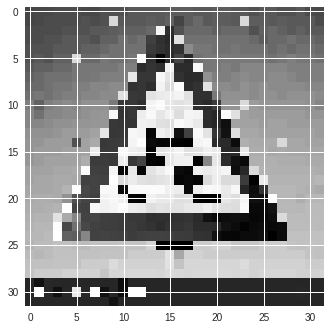

In [316]:
#Preprocess image
 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
 


In [317]:
#Reshape reshape
 
img = img.reshape(1, 32, 32, 1)
 
#Test image
print("predicted sign: "+ str(model.predict_classes(img)))

predicted sign: [31]
